In [ ]:
# CANB8347, Hossein Jashnsaz, ODEs, Mar2 and Mar7, spring 2023

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp, odeint
plt.style.use('seaborn-poster')
from sympy import pprint

## define input functions of time
a step change in stimuli or drug over time

In [2]:
# step function
def step_fxn(t,step_time,step_size):
    if t<step_time:
        return 1
    else:
        return 1+step_size

## Regulation Functions

In [3]:
# Regulation Functions
def mass_action(in1, in2, par): # mass action
    return par * in1 * in2

def michaelis_menten(in1, in2, par1, par2): # Michaelis-Menten
    return par1 * in1 * in2 / (par2 + in2)
    # par1 is k_cat, in1 is [E], in2 is [S], par2 is k_M

## define circut motif network:
### define these for your models and include a Network Representation figure here for your models
#### a Feed-Forward Loop:
input activates A <br>
A activates B <br>
A activates C <br>
B activates C <br>
A, B, C have basal deactivation <br>
input change as a step function 

## Matrices

In [4]:
regulations = "mass_action" # mass_action or Michaelis_Menten
IN = lambda t: step_fxn(t,0,.5) # set input function

# Network nodes names
NodesNames = ['[A]', '[B]', '[C]']

# Input Matrix: set which nodes receive inputs
I = np.array([[1], [0], [0]])

# Network Interaction Matrix: set which node regulate which
M = np.array([[0, 0, 0],
              [1, 0, 0],
              [1, 1, 0]])

# Basal Regulation Matrix
b = np.array([[-1], [-1], [-1]])

# number of nodes and number of parameters
n_nodes = I.shape[0]

if regulations=="mass_action":
    print("mass action regulations")
    n_params = (np.count_nonzero(I) + np.count_nonzero(M) + np.count_nonzero(b))
else:
    print("Michaelis-Menten regulations")
    n_params = 2 * (np.count_nonzero(I) + np.count_nonzero(M) + np.count_nonzero(b))
    
n_params

mass action regulations


7

## define the model

In [5]:
def model(S,t):
    A = S[0]
    B = S[1]
    C = S[2]
    
    dAdt = mass_action(IN(t), (1-A), K[0]) + mass_action(b[0][0], A, K[1])
    dBdt = mass_action(A, (1-B), K[2]) + mass_action(b[1][0], B, K[3])
    dCdt = mass_action(A, (1-C), K[4]) + mass_action(B, (1-C), K[5]) + mass_action(b[2][0], C, K[6])      
    
    ODE=[dAdt, dBdt, dCdt]
    return ODE

## solve and plot the model for a given parameter set


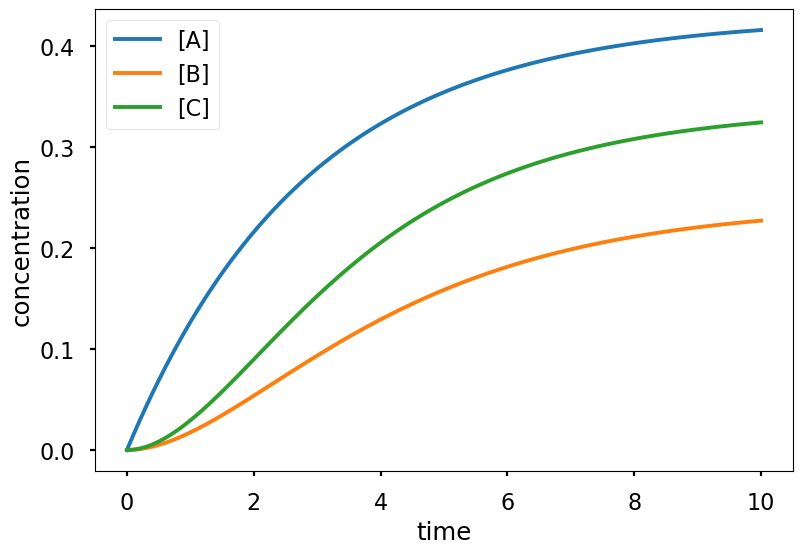

In [6]:
# solve the model for a given parameter set
K=[.1,.2,.3,.4,.5,.6,.7] # add/remove to have n_params elements
S0 = [0,0,0] ## Initial Conditions
t = np.linspace(0,10,100) # timepoints
S = odeint(model,S0,t) # ODE solver

# plot the concentrations of the nodes
plt.figure(figsize=(9,6))
plt.plot(t,S)
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend(NodesNames)
plt.show()

## sample parameter sets

In [7]:
n_param_sets = 10000

In [8]:
## normal distribution
# mu = np.zeros(n_params)
# cov = .1*np.eye(n_params)
# params = 10**np.random.multivariate_normal(mu, cov, 100) # multivariate_normal

In [9]:
# uniform distribution
params = 10**np.random.uniform(-1, 1, [n_param_sets,n_params]) # uniform
print(params.shape)

(10000, 7)


## solve the model for the parameter sets

(100, 3, 10000)
solving model for all params sets ...


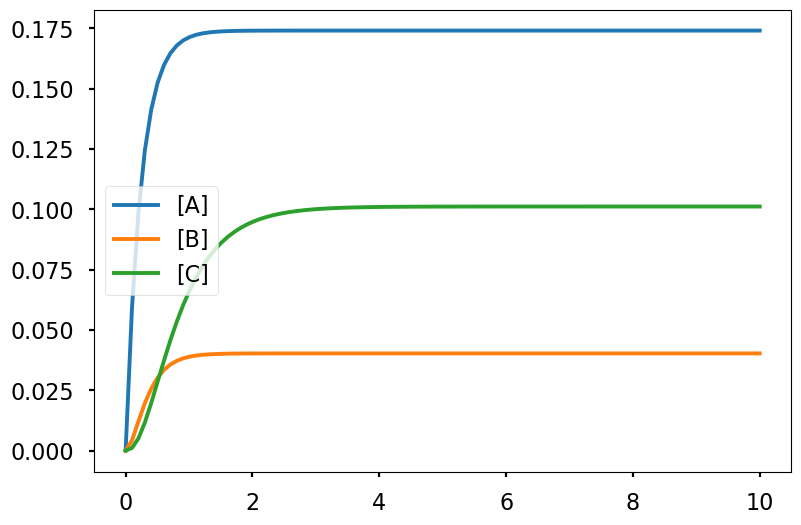

(100, 3, 10000)


In [10]:
SS=np.empty((len(t),3,n_param_sets)) # initialize empty array for the solutions
print(SS.shape)
print('solving model for all params sets ...')
for i in range(n_param_sets):
    K = params[i][:] # parameter set ith row
    SS[:,:,i] = odeint(model,S0,t) # solve model for K and save results in SS
    
# plot 1st solution 
plt.figure(figsize=(9,6))
plt.plot(t,SS[:,:,0])
plt.legend(NodesNames)
plt.show()
print(SS.shape)

## define adaptation function

In [26]:
## define adaptation function
def adaptation(C): 
    SENS = np.nanmax(C)
    PREC = 1/C[-1]
    # Adaptation: C_end < C_max - 0.1, also minimum signal of .1, and C doesn't go beyond [0,1]
    if (C[-1]<np.max(C)-.1)*(SENS>.1)*(np.max(C)<=1)*(np.min(C)>=0):
        Adaptive = 1
    else:
        Adaptive = 0
    return [SENS, PREC, Adaptive]
# C is the concentration/activity of node C over time for any given parameter set.

## calculate sensitivity, precision, and adaptation

In [27]:
## calculate sensitivity, precision, and adaptation for all parameter sets
sens, prec, adapt = [], [], [] # initialize
def SENS_PREC_ADAPT(C): # a function call to get adaptation() outputs
    out1,out2,out3 = adaptation(C)
    sens.append(out1)
    prec.append(out2)
    adapt.append(out3)
    
# call function
for i in range(n_param_sets):
    C = SS[:,2,i]
    SENS_PREC_ADAPT(C)

In [25]:
# how many parameter sets acheive adaptation
N_adaptive = np.count_nonzero(adapt)
print(N_adaptive)

0


## Plot log10(PREC) vs log10(SENS) 

Text(0, 0.5, 'log10(prec)')

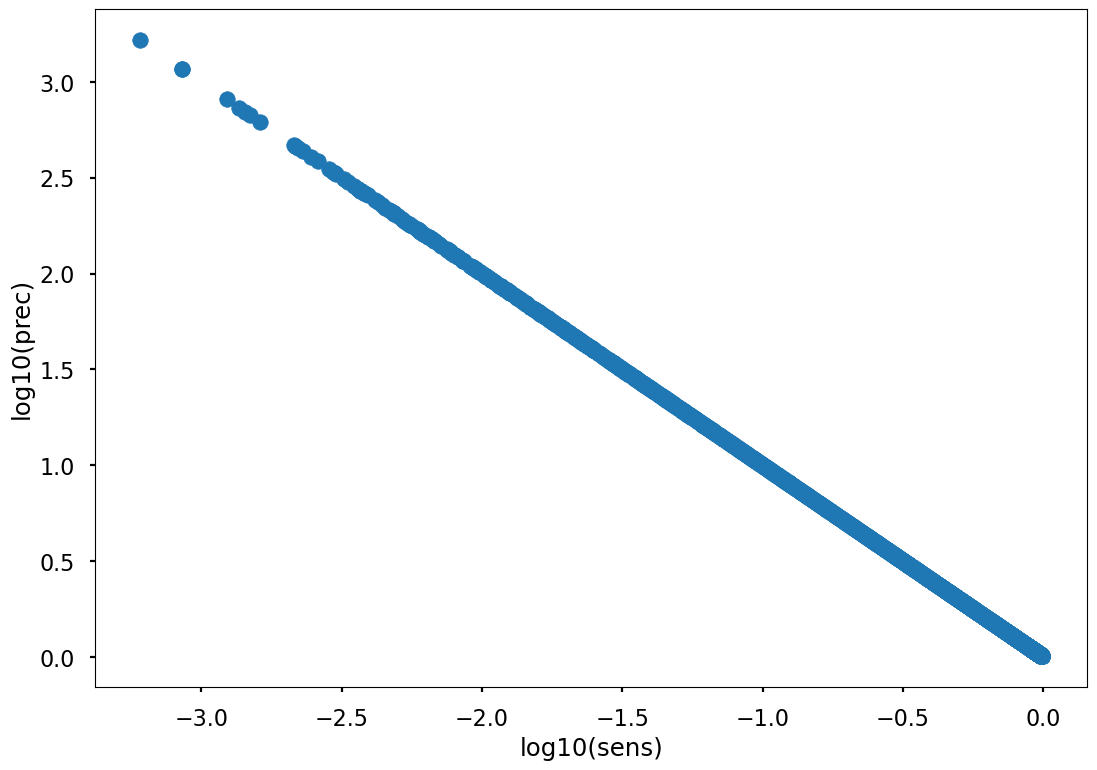

In [15]:
# Plot log10(PREC) vs log10(SENS)
plt.scatter(np.log10(sens),np.log10(prec))
plt.xlabel('log10(sens)')
plt.ylabel('log10(prec)')

## get adaptive solutions and parameter sets

In [16]:
# get adaptive solutions and parameter sets
adapt_SS=np.empty((len(t),3,N_adaptive)) # initialize empty array for the adaptive solutions
adapt_params=np.empty((N_adaptive,n_params)) # initialize empty array for the adaptive paramsets
count = 0
for i in range(n_param_sets):
    if adapt[i]==1:
        adapt_SS[:,:,count] = SS[:,:,count] # [A,B,C] get adaptive solutions
        adapt_params[count,:] = params[count,:] # get adaptive parameter sets
        count +=1
adapt_SS.shape
# if the number of adaptive parameter sets are 0, 
# 1) increase the number of samples (1e4, 2e4, 5e4), if this doesn't help
# 2) do the analysis using parameter sets for which [C] converges to a specific range e.g. [0.8, 0.9]

(100, 3, 0)

In [17]:
import ipywidgets as widgets # Importing library
from ipywidgets import interact, interactive, HBox, Layout, VBox #  importing modules and functions.

In [18]:
def results_viewer(param_set_id): # a slider to look at few solutions
    plt.figure(figsize=(16,5))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.plot(t,adapt_SS[:,i,param_set_id])
        plt.xlabel('time')
        plt.ylabel(NodesNames[i])
    plt.tight_layout()
    plt.show()

following codes calls the slider viewer to plot 

In [19]:

# Defining an interactive plot
interactive_plot = interactive(results_viewer,                        
                               param_set_id = widgets.IntSlider(min=0,max=adapt_params.shape[0]-1,step=1,value=0,description='param set'))       # param sets slider
# Creates the controls
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
# Creates the outputs
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))

TraitError: setting max < min

## scatterplots of adaptive parameter sets


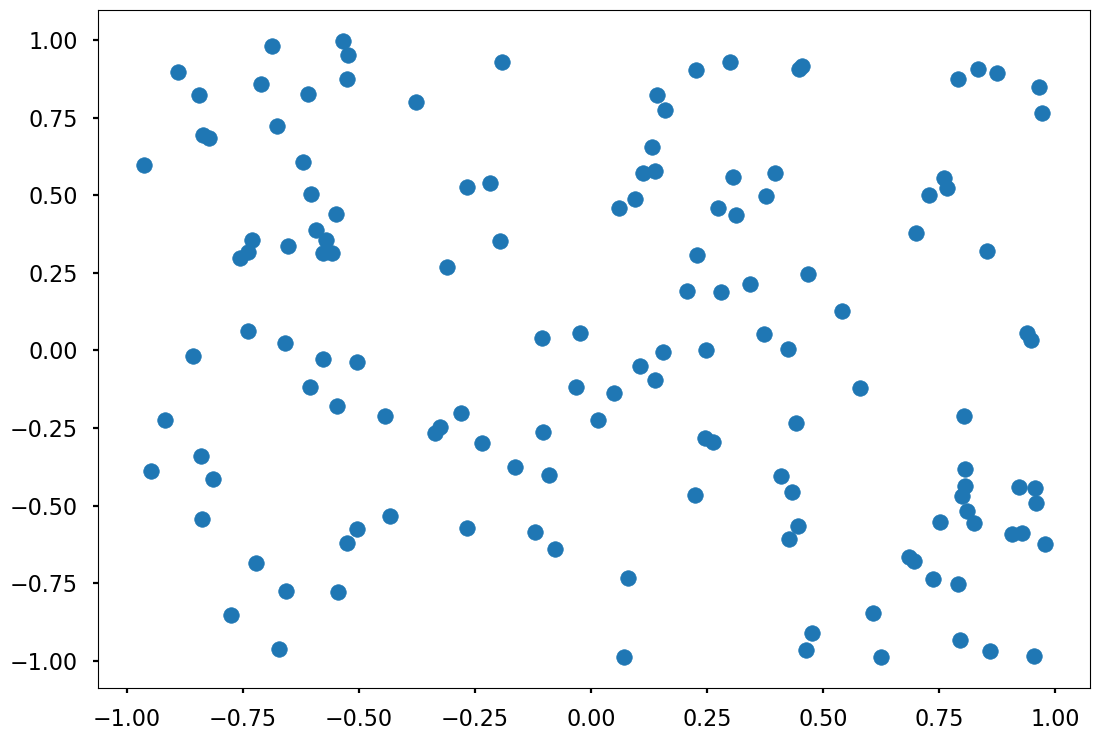

In [361]:
plt.scatter(np.log10(adapt_params[:,1]),np.log10(adapt_params[:,2]))